## 1. Network Preparation

In [13]:
# Standard library
import os
import re
import sys
import warnings
from pathlib import Path

# Third-party - Data and scientific computing
import contextily as cx
import geopandas as gpd
import igraph as ig
import numpy as np
import pandas as pd
from pyproj import Geod
from tqdm import tqdm

# Shapely-specific imports for spatial analysis
import shapely
from shapely import STRtree
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import nearest_points, snap

# Matplotlib-specific imports for figures
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Add project root to path
sys.path.append(str(Path().resolve().parent))
from src.simplify import *

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [14]:
BASE_DIR = Path.cwd().parent   # if notebook is in /notebooks
data_path = BASE_DIR / "input_files"
figure_path = BASE_DIR / "figures"
intermediate_path = BASE_DIR / 'intermediate_results'

roads_path = data_path / "roads_serbia_original_full_AADT.parquet"
pers_network = gpd.read_parquet(roads_path)

In [15]:
attributes = ['objectid','oznaka_deo','smer_gdf1','kategorija','oznaka_put','oznaka_poc','naziv_poce', 'oznaka_zav', 'naziv_zavr', 'duzina_deo',
       'pocetna_st', 'zavrsna_st','stanje','geometry']                                                

pers_network = pers_network[attributes]

In [16]:
def snap_network_iteratively(gdf, tolerance=2, search_buffer=30):
    """
    Iteratively snap road endpoints to nearby endpoints OR nearby road segments.
    Uses spatial index for efficiency.
    """
    
    def get_endpoints(geom):
        if geom is None or geom.is_empty:
            return None, None
        
        if isinstance(geom, MultiLineString):
            lines = list(geom.geoms)
            if len(lines) == 0:
                return None, None
            first_line = lines[0]
            last_line = lines[-1]
            start_coords = list(first_line.coords)[0]
            end_coords = list(last_line.coords)[-1]
            return Point(start_coords), Point(end_coords)
        
        elif isinstance(geom, LineString):
            coords = list(geom.coords)
            return Point(coords[0]), Point(coords[-1])
        
        else:
            return None, None
    
    gdf = gdf.copy()
    total_snaps = 0
    indices = list(gdf.index)
    
    # Track pairs that have already been snapped
    already_snapped_pairs = set()
    
    iteration = 0
    while True:
        iteration += 1
        snaps_this_round = 0
        snapped_this_round = set()
        
        # Build spatial index fresh each iteration
        geometries = gdf.geometry.tolist()
        tree = STRtree(geometries)
        idx_to_pos = {idx: i for i, idx in enumerate(indices)}
        pos_to_idx = {i: idx for i, idx in enumerate(indices)}
        
        for idx1 in tqdm(indices, desc=f"Iteration {iteration}"):
            if idx1 in snapped_this_round:
                continue
            
            geom1 = gdf.loc[idx1, 'geometry']
            if geom1 is None or geom1.is_empty:
                continue
                
            start1, end1 = get_endpoints(geom1)
            if start1 is None:
                continue
            
            # Find candidate roads within buffer
            buffer_geom = geom1.buffer(search_buffer)
            candidate_positions = tree.query(buffer_geom)
            candidate_indices = [pos_to_idx[pos] for pos in candidate_positions]
            
            for pt1, pos1 in [(start1, 'start'), (end1, 'end')]:
                if idx1 in snapped_this_round:
                    break
                
                for idx2 in candidate_indices:
                    if idx1 == idx2:
                        continue
                    
                    # Skip if this pair was already snapped
                    pair = tuple(sorted([idx1, idx2]))
                    if pair in already_snapped_pairs:
                        continue
                    
                    geom2 = gdf.loc[idx2, 'geometry']
                    if geom2 is None or geom2.is_empty:
                        continue
                    
                    dist = pt1.distance(geom2)
                    
                    if 0 < dist <= tolerance:
                        gdf.loc[idx1, 'geometry'] = snap(
                            gdf.loc[idx1, 'geometry'], 
                            geom2, 
                            tolerance
                        )
                        snapped_this_round.add(idx1)
                        already_snapped_pairs.add(pair)
                        snaps_this_round += 1
                        
                        start1, end1 = get_endpoints(gdf.loc[idx1, 'geometry'])
                        break
        
        print(f"Iteration {iteration} complete: {snaps_this_round} snaps")
        total_snaps += snaps_this_round
        
        if snaps_this_round == 0:
            break
        if iteration > 20:
            print("Max iterations reached")
            break
    
    print(f"\nTotal snaps made: {total_snaps}")
    return gdf

In [17]:
# Run it
pers_network = snap_network_iteratively(pers_network, tolerance=2, search_buffer=30)

Iteration 1: 100%|██████████| 2560/2560 [00:03<00:00, 745.82it/s] 


Iteration 1 complete: 267 snaps


Iteration 2: 100%|██████████| 2560/2560 [00:02<00:00, 863.96it/s] 


Iteration 2 complete: 56 snaps


Iteration 3: 100%|██████████| 2560/2560 [00:02<00:00, 871.65it/s] 


Iteration 3 complete: 5 snaps


Iteration 4: 100%|██████████| 2560/2560 [00:02<00:00, 859.85it/s] 

Iteration 4 complete: 0 snaps

Total snaps made: 328


In [18]:
# Create a Network object from the input DataFrame
net = Network(edges=pers_network)

In [19]:
net = add_endpoints(net)
net = split_edges_at_nodes(net,attributes=['objectid','oznaka_deo','smer_gdf1','kategorija',
                                           'oznaka_put','oznaka_poc','naziv_poce', 'oznaka_zav', 
                                           'naziv_zavr', 'duzina_deo','pocetna_st', 'zavrsna_st','stanje'])
net = add_endpoints(net)
net = add_ids(net)
net = add_topology(net)    

topology: 100%|██████████| 3423/3423 [00:00<00:00, 6720.92it/s]


In [20]:
pers_network = net.edges.set_crs(pers_network.crs)

In [21]:
AADT_path = data_path / "PGDS_2024.shp"
aadt_network = gpd.read_file(AADT_path)

In [22]:
aadt_cols = ['PA', 'BUS', 'LT', 'ST', 'TT', 'AV', 'Ukupno']
aadt_network.dropna(subset=aadt_cols, inplace=True)

In [23]:
aadt_network

OBJECTID oznaka_deo smer kategorija oznaka_put oznaka_poc  \
3            4      A2003    D         IA         A2       A201   
4            5      A1002    L         IA         A1       A101   
6            7      A1003    D         IA         A1       A101   
9           10      A1004    L         IA         A1       A102   
11          12      A1005    D         IA         A1       A102   
...        ...        ...  ...        ...        ...        ...   
1978      1979      02109    O         IB         21       2108   
1979      1980      10506    O        IIA        105      10504   
1980      1981      A8001    D         IA         A8       A305   
1981      1982      A8902    L         IA         A8       A890   
1982      1983      A8002    L         IA         A8       A801   

                             naziv_poce oznaka_zav                naziv_zavr  \
3                         petlja Jakovo       A202          petlja Obrenovac   
4                         petlja Horgoš       A100  granica MAĐ/SRB (Horgoš)   
6                         petlja Horgoš       A102     petlja Subotica sever   
9                 petlja Subotica sever       A101             petlja Horgoš   
11                petlja Subotica sever       A103     petlja Subotica istok   
...                                 ...        ...                       ...   
1978             Ruma (veza sa A3 i A8)       2109                     Jarak   
1979               Bačka Topola (Bečej)       A106       petlja Bačka Topola   
1980                        petlja Ruma       A801           petlja Hrtkovci   
1981  Šabac (kraj izgrađenog auto-puta)       A801           petlja Hrtkovci   
1982                    petlja Hrtkovci       A305               petlja Ruma   

      duzina_deo  ...  BUS   LT   ST   TT    AV Ukupno     Napomena  \
3         14.153  ...  312  473  378  320  2210  25610  АБС 1366/67   
4          4.245  ...  101   88   30   11   954   6260  АБС 2089/90   
6         12.603  ...  132  114   76   34  1192   7892          ИНТ   
9         12.607  ...  132  114   76   34  1192   7892          ИНТ   
11         6.296  ...  142  165  101   60  1483   9807          ИНТ   
...          ...  ...  ...  ...  ...  ...   ...    ...          ...   
1978       8.378  ...  119  184  235  153  1343  10709          ИНТ   
1979       4.343  ...   10   69   50   70   188   3890          ИНТ   
1980      12.956  ...   94  143  108   78   750   7013           НП   
1981      10.451  ...   70  106   80   58   557   5209           НП   
1982      12.965  ...   94  143  108   78   750   7013           НП   

     SHAPE_Le_1    Shape_Le_2  \
3           0.0  14145.406343   
4           0.0   4256.939514   
6           0.0  12606.773137   
9           0.0  12599.869429   
11          0.0   6296.138018   
...         ...           ...   
1978        0.0   8381.020610   
1979        0.0   4311.893771   
1980        0.0  12956.380355   
1981        0.0  10450.807271   
1982        0.0  12964.767619   

                                               geometry  
3     LINESTRING (7440814.837 4958177.242, 7440814.3...  
4     LINESTRING (7418334.847 5112650.115, 7418343.3...  
6     LINESTRING (7418315.606 5112663.751, 7418314.9...  
9     LINESTRING (7407247.012 5107612.838, 7407259.8...  
11    LINESTRING (7407224.474 5107619.124, 7407215.1...  
...                                                 ...  
1978  LINESTRING (7406514.94 4981400.47, 7406518.786...  
1979  LINESTRING (7395081.26 5074820.11, 7395078.44 ...  
1980  LINESTRING (7406240.29 4980567.49, 7406237.77 ...  
1981  LINESTRING (7396193.009 4963420.889, 7396199.0...  
1982  LINESTRING (7403593.826 4969333.468, 7403602.1...  

[1019 rows x 28 columns]

In [24]:
traffic_types = ['passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
                 'heavy_trucks', 'articulated_vehicles', 'total_aadt']

In [25]:
aadt_cols = ['PA', 'BUS', 'LT', 'ST', 'TT', 'AV', 'Ukupno']
aadt_network.dropna(subset=aadt_cols, inplace=True)

# First merge on oznaka_deo
first_merger = pers_network.merge(
    aadt_network[aadt_cols+['oznaka_deo']], 
    how='left', 
    left_on='oznaka_deo', 
    right_on='oznaka_deo'
)

# Spatial join for unmatched rows
overlap = first_merger.loc[first_merger.PA.isna()][pers_network.columns].sjoin(
    aadt_network[aadt_cols+['oznaka_deo','geometry']], 
    how='left', 
    predicate='intersects'
)

# Get the AADT geometries for the matched index_right values
overlap_with_aadt_geom = overlap.dropna(subset=['index_right']).copy()
overlap_with_aadt_geom['aadt_geometry'] = aadt_network.loc[overlap_with_aadt_geom['index_right'].astype(int), 'geometry'].values

# Calculate intersection and overlap ratio
overlap_with_aadt_geom['intersection_geom'] = overlap_with_aadt_geom.apply(
    lambda row: row['geometry'].intersection(row['aadt_geometry']), axis=1
)
overlap_with_aadt_geom['overlap_ratio'] = (
    overlap_with_aadt_geom['intersection_geom'].length / overlap_with_aadt_geom['geometry'].length
)

# Keep only rows with >= 50% overlap
overlap_filtered = overlap_with_aadt_geom[overlap_with_aadt_geom['overlap_ratio'] >= 0.5].copy()
overlap_filtered = overlap_filtered.drop(columns=['aadt_geometry', 'intersection_geom', 'overlap_ratio'])

first_cols = ['oznaka_deo_left', 'smer_gdf1', 'kategorija', 'oznaka_put', 'oznaka_poc', 
              'naziv_poce', 'oznaka_zav', 'naziv_zavr', 'duzina_deo', 'pocetna_st', 
              'geometry', 'index_right', 'oznaka_deo_right']

agg_dict = {col: 'first' for col in first_cols}
agg_dict.update({col: 'max' for col in aadt_cols})

result = overlap_filtered.dropna(subset=aadt_cols).groupby(level=0).agg(agg_dict)

# Continue with concatenation...
AADT_connected = pd.concat([first_merger.loc[first_merger.dropna(subset=aadt_cols).index], result])
AADT_connected = gpd.GeoDataFrame(pd.concat([AADT_connected,pers_network.loc[~pers_network.index.isin(AADT_connected.index)]]))

AADT_connected = AADT_connected.rename(columns = {
    'PA' : 'passenger_cars', 
    'BUS': 'buses', 
    'LT': 'light_trucks', 
    'ST': 'medium_trucks',  
    'TT': 'heavy_trucks', 
    'AV': 'articulated_vehicles', 
    'Ukupno': 'total_aadt'
}
                     )

AADT_connected[traffic_types] = AADT_connected[traffic_types].astype(np.float64)

# Ensure it's a GeoDataFrame with proper CRS
AADT_connected = gpd.GeoDataFrame(AADT_connected, geometry='geometry')

traffic_cols = ['passenger_cars', 'buses', 'light_trucks', 'medium_trucks', 
                'heavy_trucks', 'articulated_vehicles', 'total_aadt']



c:\Users\yma794\AppData\Local\miniforge3\envs\serbia\Lib\site-packages\geopandas\array.py:1754: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as MGI 1901 / Balkans zone 7 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [ ]:
def get_endpoints(geom):
    """Get start and end points of a linestring or multilinestring"""
    if geom is None or geom.is_empty:
        return None, None
    
    # Handle MultiLineString
    if isinstance(geom, MultiLineString):
        # Get all component linestrings
        lines = list(geom.geoms)
        if len(lines) == 0:
            return None, None
        # Get start of first line and end of last line
        first_line = lines[0]
        last_line = lines[-1]
        start_coords = list(first_line.coords)[0]
        end_coords = list(last_line.coords)[-1]
        return Point(start_coords), Point(end_coords)
    
    # Handle regular LineString
    elif isinstance(geom, LineString):
        coords = list(geom.coords)
        return Point(coords[0]), Point(coords[-1])
    
    else:
        return None, None

def find_touching_roads_with_aadt(idx, gdf, buffer_dist=1):
    """Find roads that touch the endpoints of a given road and have AADT values"""
    row = gdf.loc[idx]
    start_pt, end_pt = get_endpoints(row.geometry)
    
    if start_pt is None:
        return []
    
    touching_roads = []
    for other_idx, other_row in gdf.iterrows():
        if other_idx == idx:
            continue
        if pd.isna(other_row['total_aadt']):
            continue
            
        # Check if endpoints touch the other road
        if other_row.geometry is not None and not other_row.geometry.is_empty:
            if start_pt.buffer(buffer_dist).intersects(other_row.geometry):
                touching_roads.append(('start', other_idx, other_row))
            if end_pt.buffer(buffer_dist).intersects(other_row.geometry):
                touching_roads.append(('end', other_idx, other_row))
    
    return touching_roads

# ============================================
# PASS 1: Fill from both endpoints touching roads with AADT
# ============================================
print("Pass 1: Filling from roads touching both endpoints...")

missing_aadt = AADT_connected[AADT_connected['total_aadt'].isna()].index.tolist()
filled_count_pass1 = 0

for idx in tqdm(missing_aadt,total=len(missing_aadt)):
    touching = find_touching_roads_with_aadt(idx, AADT_connected)
    
    # Check if we have at least one touch at start and one at end
    start_touches = [t for t in touching if t[0] == 'start']
    end_touches = [t for t in touching if t[0] == 'end']
    
    if len(start_touches) > 0 and len(end_touches) > 0:
        # Get AADT values from touching roads
        start_values = {col: np.mean([t[2][col] for t in start_touches]) for col in traffic_cols}
        end_values = {col: np.mean([t[2][col] for t in end_touches]) for col in traffic_cols}
        
        # Take average of start and end
        for col in traffic_cols:
            AADT_connected.loc[idx, col] = (start_values[col] + end_values[col]) / 2
        
        filled_count_pass1 += 1

print(f"Pass 1 filled {filled_count_pass1} roads")

# ============================================
# PASS 2: Fill with median by kategorija, then cap by touching roads
# ============================================
print("Pass 2: Filling with kategorija median...")

# Calculate median values per kategorija
kategoria_medians = AADT_connected.groupby('kategorija')[traffic_cols].median()

missing_aadt = AADT_connected[AADT_connected['total_aadt'].isna()].index.tolist()
filled_count_pass2 = 0

for idx in tqdm(missing_aadt,total=len(missing_aadt)):
    row = AADT_connected.loc[idx]
    kategorija = row['kategorija']
    
    # Skip if no kategorija
    if pd.isna(kategorija) or kategorija not in kategoria_medians.index:
        continue
    
    # Fill with median values
    median_values = kategoria_medians.loc[kategorija]
    for col in traffic_cols:
        AADT_connected.loc[idx, col] = median_values[col]
    
    # Now check touching roads and cap if our value is higher
    touching = find_touching_roads_with_aadt(idx, AADT_connected)
    
    if len(touching) > 0:
        # Get max AADT from any touching road
        max_touching_values = {col: max([t[2][col] for t in touching]) for col in traffic_cols}
        
        # Cap our values if they exceed touching roads
        for col in traffic_cols:
            if AADT_connected.loc[idx, col] > max_touching_values[col]:
                AADT_connected.loc[idx, col] = max_touching_values[col]
    
    filled_count_pass2 += 1

print(f"Pass 2 filled {filled_count_pass2} roads")

# Summary
remaining_missing = AADT_connected['total_aadt'].isna().sum()
print(f"\nRemaining roads without AADT: {remaining_missing}")

Pass 1: Filling from roads touching both endpoints...


  0%|          | 0/1940 [00:00<?, ?it/s]

100%|██████████| 1940/1940 [10:58<00:00,  2.94it/s]


Pass 1 filled 234 roads
Pass 2: Filling with kategorija median...


 24%|██▍       | 416/1706 [02:21<08:07,  2.65it/s]

In [ ]:
# Load country outline
world_path = data_path / "ne_10m_admin_0_countries.shp"
world = gpd.read_file(world_path)
country = world.loc[world.SOV_A3 == 'KOS']
country = country.to_crs(AADT_connected.crs)

# Dissolve in case there are multiple polygons
kosovo_geom = country.union_all()  # or country.unary_union for older geopandas

# Filter roads that are within Serbia
AADT_Serbia = AADT_connected[~AADT_connected.geometry.intersects(kosovo_geom)].copy()

### PREPARE SEVERAL MAPS TO CHECK THE RESULTS (AND FOR THE REPORT)

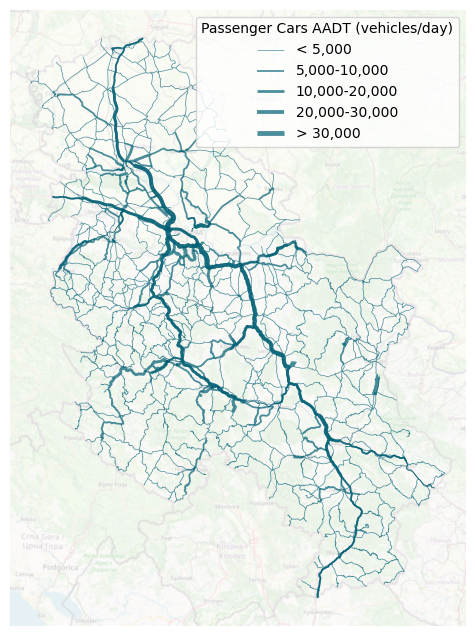

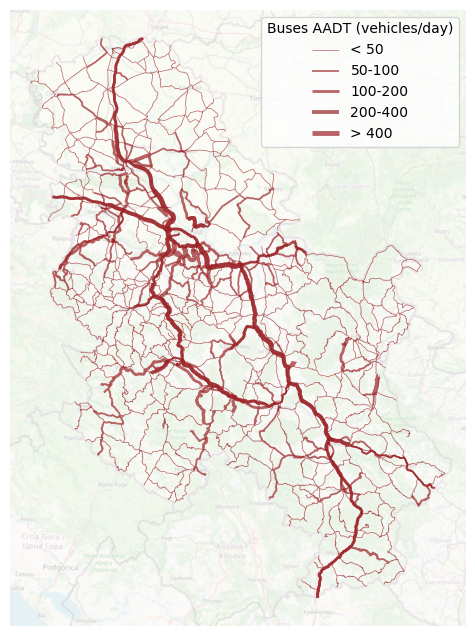

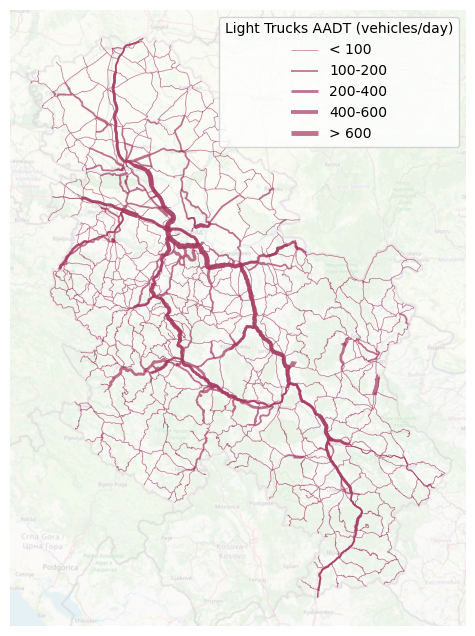

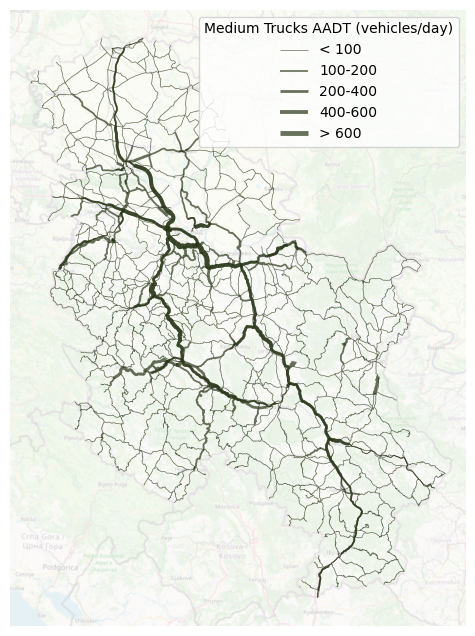

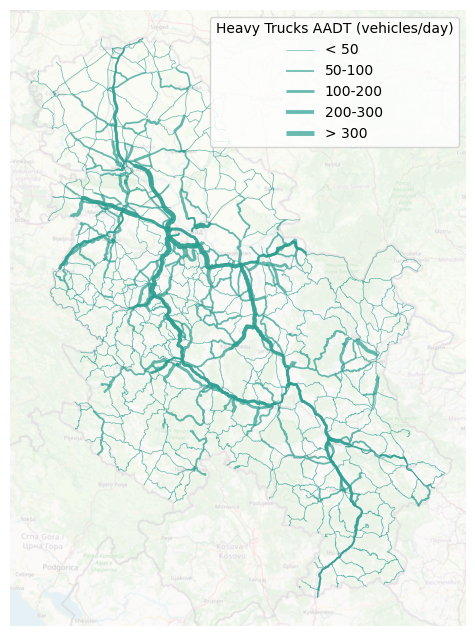

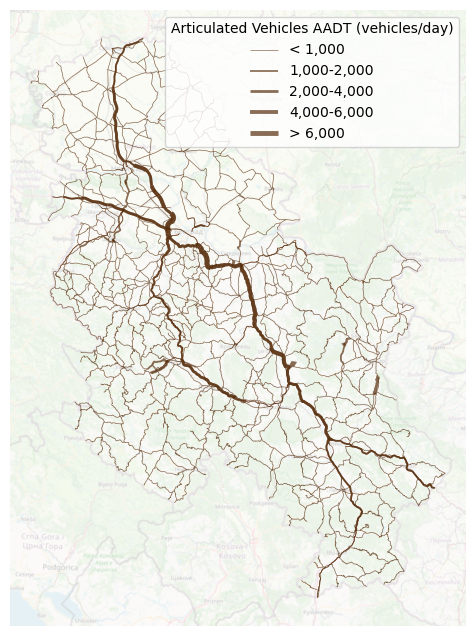

In [ ]:
gdf_aadt = AADT_Serbia.copy()

traffic_types = ['passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
                 'heavy_trucks', 'articulated_vehicles', 'total_aadt']

colors = ['#005f73','#9b2226','#a53860','#283618','#2a9d8f','#582f0e','#001219']

legend_titles = {
    'passenger_cars': 'Passenger Cars AADT (vehicles/day)',
    'buses': 'Buses AADT (vehicles/day)', 
    'light_trucks': 'Light Trucks AADT (vehicles/day)',
    'medium_trucks': 'Medium Trucks AADT (vehicles/day)',
    'heavy_trucks': 'Heavy Trucks AADT (vehicles/day)',
    'articulated_vehicles': 'Articulated Vehicles AADT (vehicles/day)',
    'total_aadt': 'Total AADT (vehicles/day)'
}

breaks_labels = {
    'passenger_cars': ([0, 5000, 10000, 20000, 30000, float('inf')], 
                      ['< 5,000', '5,000-10,000', '10,000-20,000', '20,000-30,000', '> 30,000']),
    'buses': ([0, 50, 100, 200, 400, float('inf')], 
              ['< 50', '50-100', '100-200', '200-400', '> 400']),
    'light_trucks': ([0, 100, 200, 400, 600, float('inf')], 
                    ['< 100', '100-200', '200-400', '400-600', '> 600']),
    'medium_trucks': ([0, 100, 200, 400, 600, float('inf')], 
                     ['< 100', '100-200', '200-400', '400-600', '> 600']),
    'heavy_trucks': ([0, 50, 100, 200, 300, float('inf')], 
                    ['< 50', '50-100', '100-200', '200-300', '> 300']),
    'articulated_vehicles': ([0, 1000, 2000, 4000, 6000, float('inf')], 
                           ['< 1,000', '1,000-2,000', '2,000-4,000', '4,000-6,000', '> 6,000']),
    'total_aadt': ([0, 5000, 10000, 20000, 40000, float('inf')], 
                  ['< 5,000', '5,000-10,000', '10,000-20,000', '20,000-40,000', '> 40,000'])
}

width_mappings = {
    'passenger_cars': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 5,000', '5,000-10,000', '10,000-20,000', '20,000-30,000', '> 30,000'])},
    'buses': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 50', '50-100', '100-200', '200-400', '> 400'])},
    'light_trucks': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 100', '100-200', '200-400', '400-600', '> 600'])},
    'medium_trucks': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 100', '100-200', '200-400', '400-600', '> 600'])},
    'heavy_trucks': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 50', '50-100', '100-200', '200-300', '> 300'])},
    'articulated_vehicles': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 1,000', '1,000-2,000', '2,000-4,000', '4,000-6,000', '> 6,000'])},
    'total_aadt': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 5,000', '5,000-10,000', '10,000-20,000', '20,000-40,000', '> 40,000'])}
}

for i, traffic_type in enumerate(traffic_types[:6]):
    breaks, labels = breaks_labels[traffic_type]
    
    # Create categories for this traffic type
    gdf_aadt[f'{traffic_type}_category'] = pd.cut(gdf_aadt[traffic_type], 
                                                  bins=breaks, labels=labels, include_lowest=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for category in labels:
        subset = gdf_aadt[gdf_aadt[f'{traffic_type}_category'] == category]
        if len(subset) > 0:
            width = width_mappings[traffic_type][category]
            subset.plot(ax=ax, color=colors[i], alpha=0.7,
                       linewidth=width, label=category)
    
    cx.add_basemap(ax=ax, crs=gdf_aadt.crs.to_string(),
                    source=cx.providers.OpenStreetMap.Mapnik, 
                    alpha=0.3, attribution=False)
    ax.legend(title=legend_titles[traffic_type], loc='upper right')
    ax.axis('off')
    plt.savefig(figure_path / f'{traffic_type}_aadt_map.png', dpi=300, bbox_inches='tight')
    plt.show()

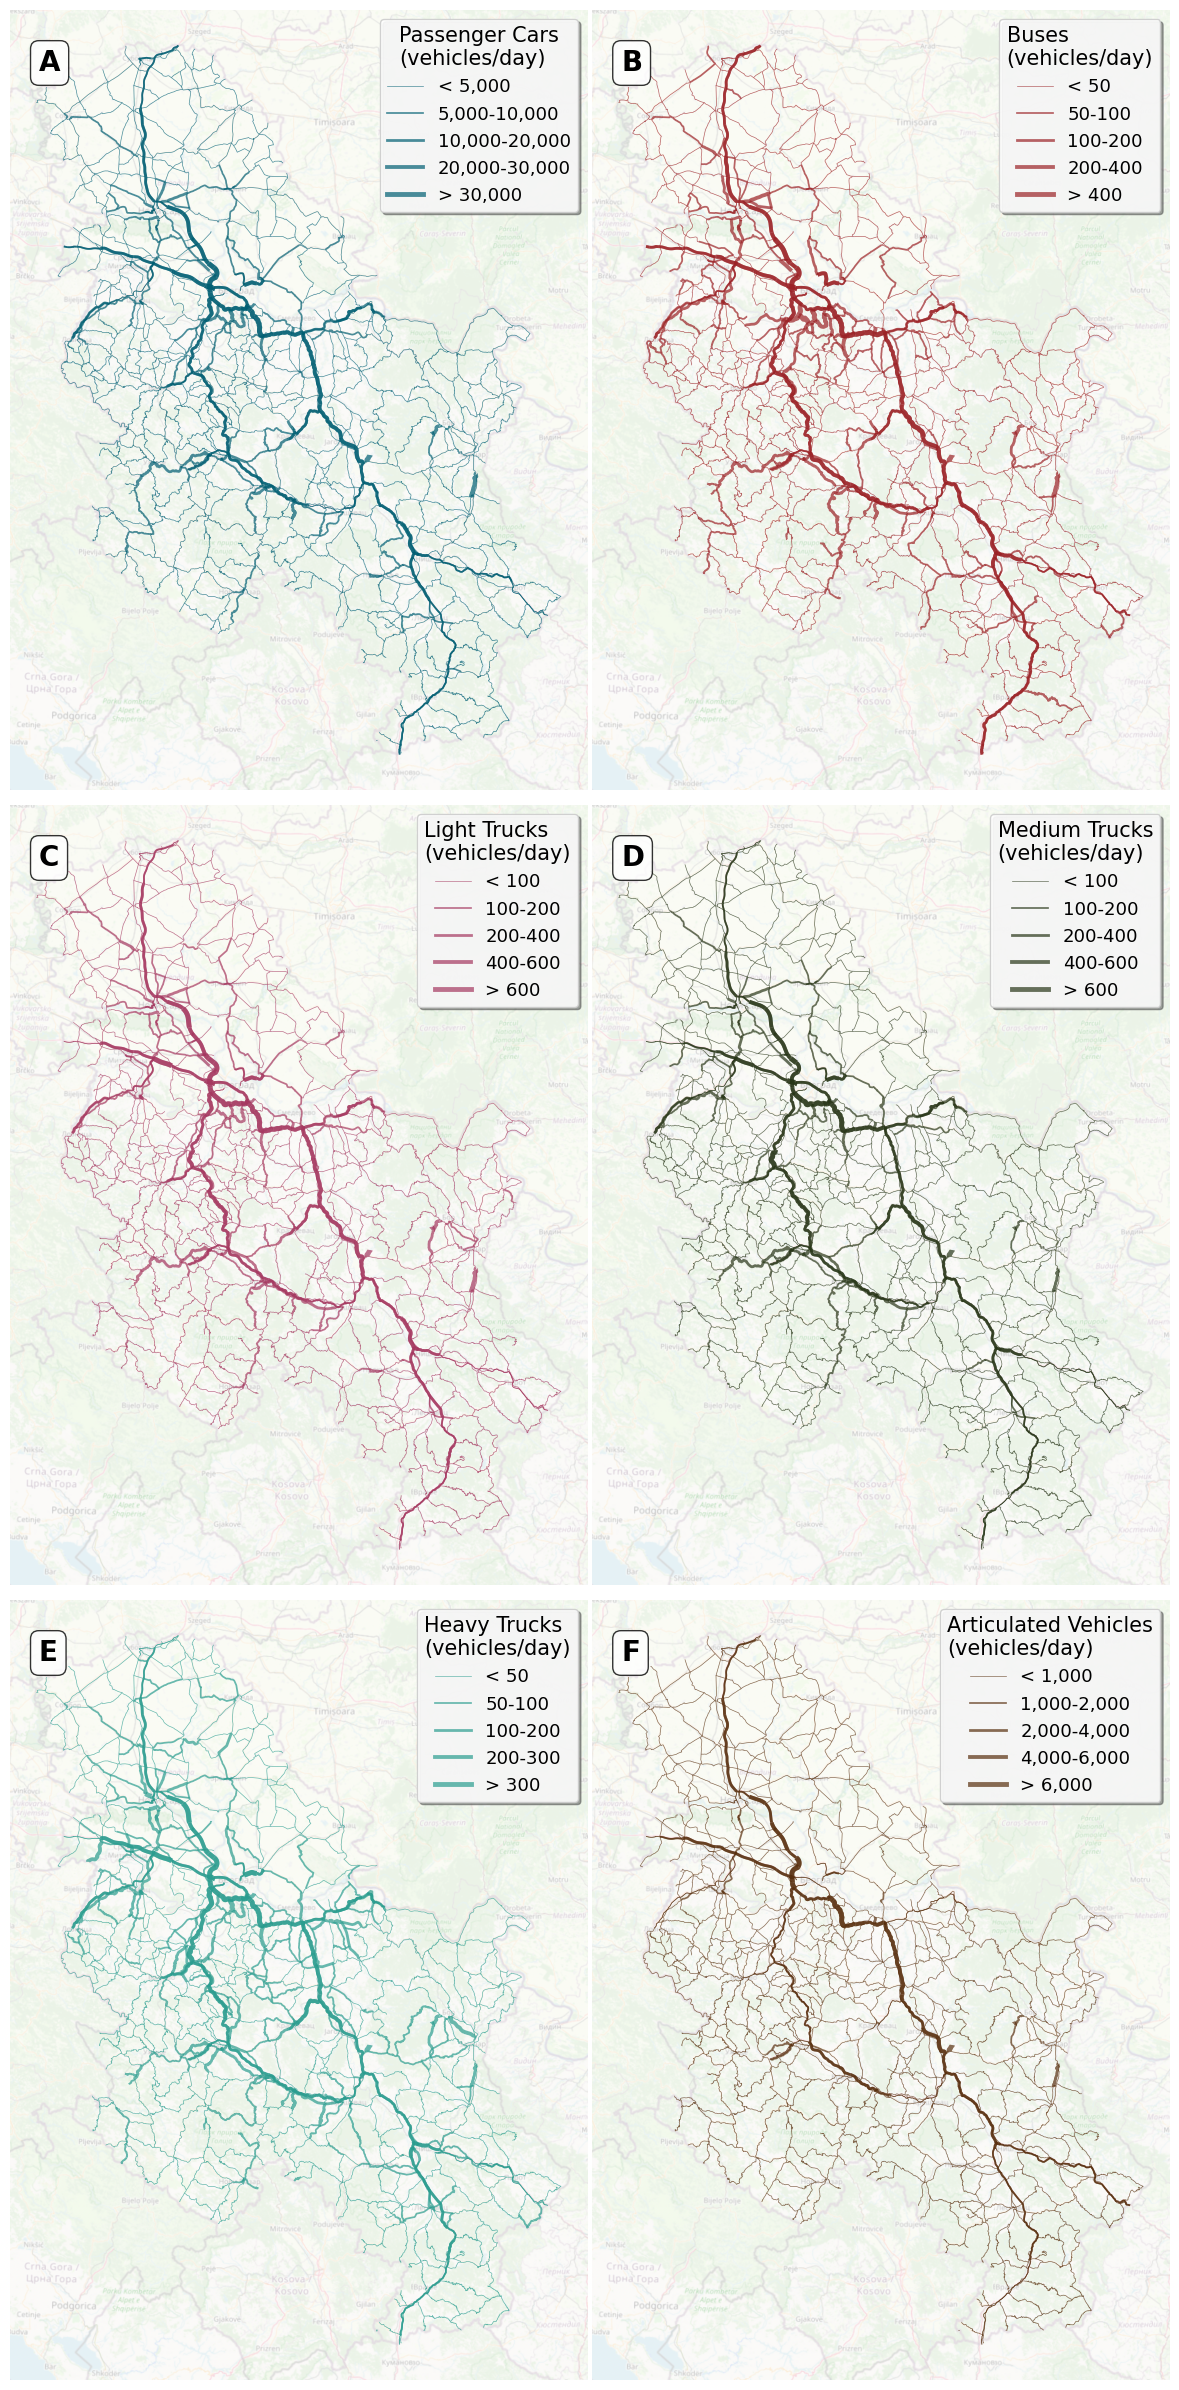

In [ ]:
gdf_aadt = AADT_Serbia.copy()

# Exclude 'total_aadt' - only 6 categories
traffic_types = ['passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
                 'heavy_trucks', 'articulated_vehicles']
colors = ['#005f73', '#9b2226', '#a53860', '#283618', '#2a9d8f', '#582f0e']
letters = ['A', 'B', 'C', 'D', 'E', 'F']

legend_titles = {
    'passenger_cars': 'Passenger Cars\n(vehicles/day)',
    'buses': 'Buses\n(vehicles/day)', 
    'light_trucks': 'Light Trucks\n(vehicles/day)',
    'medium_trucks': 'Medium Trucks\n(vehicles/day)',
    'heavy_trucks': 'Heavy Trucks\n(vehicles/day)',
    'articulated_vehicles': 'Articulated Vehicles\n(vehicles/day)'
}

breaks_labels = {
    'passenger_cars': ([0, 5000, 10000, 20000, 30000, float('inf')], 
                      ['< 5,000', '5,000-10,000', '10,000-20,000', '20,000-30,000', '> 30,000']),
    'buses': ([0, 50, 100, 200, 400, float('inf')], 
              ['< 50', '50-100', '100-200', '200-400', '> 400']),
    'light_trucks': ([0, 100, 200, 400, 600, float('inf')], 
                    ['< 100', '100-200', '200-400', '400-600', '> 600']),
    'medium_trucks': ([0, 100, 200, 400, 600, float('inf')], 
                     ['< 100', '100-200', '200-400', '400-600', '> 600']),
    'heavy_trucks': ([0, 50, 100, 200, 300, float('inf')], 
                    ['< 50', '50-100', '100-200', '200-300', '> 300']),
    'articulated_vehicles': ([0, 1000, 2000, 4000, 6000, float('inf')], 
                           ['< 1,000', '1,000-2,000', '2,000-4,000', '4,000-6,000', '> 6,000'])
}

width_mappings = {
    'passenger_cars': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 5,000', '5,000-10,000', '10,000-20,000', '20,000-30,000', '> 30,000'])},
    'buses': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 50', '50-100', '100-200', '200-400', '> 400'])},
    'light_trucks': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 100', '100-200', '200-400', '400-600', '> 600'])},
    'medium_trucks': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 100', '100-200', '200-400', '400-600', '> 600'])},
    'heavy_trucks': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 50', '50-100', '100-200', '200-300', '> 300'])},
    'articulated_vehicles': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 1,000', '1,000-2,000', '2,000-4,000', '4,000-6,000', '> 6,000'])}
}

# Create figure with 3 rows x 2 columns
fig, axes = plt.subplots(3, 2, figsize=(12, 24), facecolor='white')
axes = axes.flatten()  # Flatten to easily iterate

for i, traffic_type in enumerate(traffic_types):
    ax = axes[i]
    breaks, labels = breaks_labels[traffic_type]
    
    # Create categories for this traffic type
    gdf_aadt[f'{traffic_type}_category'] = pd.cut(
        gdf_aadt[traffic_type], 
        bins=breaks, labels=labels, include_lowest=True
    )
    
    # Plot each category
    for category in labels:
        subset = gdf_aadt[gdf_aadt[f'{traffic_type}_category'] == category]
        if len(subset) > 0:
            width = width_mappings[traffic_type][category]
            subset.plot(ax=ax, color=colors[i], alpha=0.7, linewidth=width)
    
    # Add basemap
    cx.add_basemap(ax=ax, crs=gdf_aadt.crs.to_string(),
                   source=cx.providers.OpenStreetMap.Mapnik, 
                   alpha=0.3, attribution=False)
    
    # Create legend with line widths
    legend_elements = [
        Line2D([0], [0], color=colors[i], lw=width_mappings[traffic_type][cat], 
               label=cat, alpha=0.7)
        for cat in labels
    ]
    ax.legend(handles=legend_elements, title=legend_titles[traffic_type], 
              loc='upper right', fontsize=13, title_fontsize=15,
              frameon=True, fancybox=True, shadow=True,
              framealpha=0.9, facecolor='white', edgecolor='#cccccc')
    
    ax.axis('off')
    
    # Add letter label
    ax.text(0.05, 0.95, letters[i], transform=ax.transAxes, fontsize=20, 
            fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(data_path /'AADT_categories_combined.png', dpi=300, bbox_inches='tight')
plt.show()

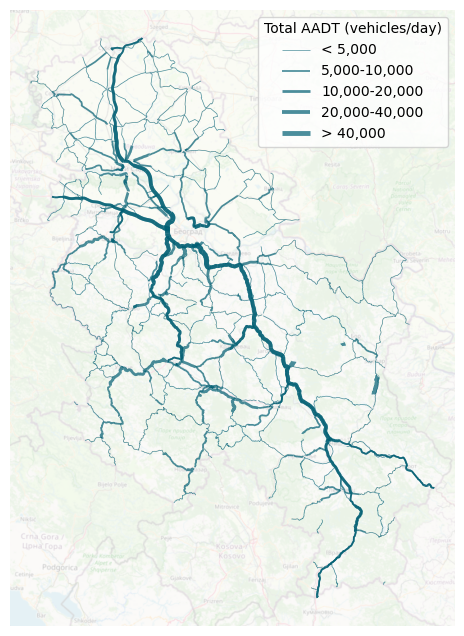

In [ ]:
gdf_aadt = aadt_network.copy()
gdf_aadt = gdf_aadt.rename(columns = {
    'PA' : 'passenger_cars', 
    'BUS': 'buses', 
    'LT': 'light_trucks', 
    'ST': 'medium_trucks',  
    'TT': 'heavy_trucks', 
    'AV': 'articulated_vehicles', 
    'Ukupno': 'total_aadt'
}
                     )

gdf_aadt[traffic_types] = gdf_aadt[traffic_types].astype(np.float64)


traffic_types = ['passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
                 'heavy_trucks', 'articulated_vehicles', 'total_aadt']

colors = ['#005f73','#9b2226','#a53860','#283618','#2a9d8f','#582f0e','#001219']

legend_titles = {
    'passenger_cars': 'Passenger Cars AADT (vehicles/day)',
    'buses': 'Buses AADT (vehicles/day)', 
    'light_trucks': 'Light Trucks AADT (vehicles/day)',
    'medium_trucks': 'Medium Trucks AADT (vehicles/day)',
    'heavy_trucks': 'Heavy Trucks AADT (vehicles/day)',
    'articulated_vehicles': 'Articulated Vehicles AADT (vehicles/day)',
    'total_aadt': 'Total AADT (vehicles/day)'
}

breaks_labels = {
    'passenger_cars': ([0, 5000, 10000, 20000, 30000, float('inf')], 
                      ['< 5,000', '5,000-10,000', '10,000-20,000', '20,000-30,000', '> 30,000']),
    'buses': ([0, 50, 100, 200, 400, float('inf')], 
              ['< 50', '50-100', '100-200', '200-400', '> 400']),
    'light_trucks': ([0, 100, 200, 400, 600, float('inf')], 
                    ['< 100', '100-200', '200-400', '400-600', '> 600']),
    'medium_trucks': ([0, 100, 200, 400, 600, float('inf')], 
                     ['< 100', '100-200', '200-400', '400-600', '> 600']),
    'heavy_trucks': ([0, 50, 100, 200, 300, float('inf')], 
                    ['< 50', '50-100', '100-200', '200-300', '> 300']),
    'articulated_vehicles': ([0, 1000, 2000, 4000, 6000, float('inf')], 
                           ['< 1,000', '1,000-2,000', '2,000-4,000', '4,000-6,000', '> 6,000']),
    'total_aadt': ([0, 5000, 10000, 20000, 40000, float('inf')], 
                  ['< 5,000', '5,000-10,000', '10,000-20,000', '20,000-40,000', '> 40,000'])
}

width_mappings = {
    'passenger_cars': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 5,000', '5,000-10,000', '10,000-20,000', '20,000-30,000', '> 30,000'])},
    'buses': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 50', '50-100', '100-200', '200-400', '> 400'])},
    'light_trucks': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 100', '100-200', '200-400', '400-600', '> 600'])},
    'medium_trucks': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 100', '100-200', '200-400', '400-600', '> 600'])},
    'heavy_trucks': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 50', '50-100', '100-200', '200-300', '> 300'])},
    'articulated_vehicles': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 1,000', '1,000-2,000', '2,000-4,000', '4,000-6,000', '> 6,000'])},
    'total_aadt': {cat: 0.5 + i * 0.75 for i, cat in enumerate(['< 5,000', '5,000-10,000', '10,000-20,000', '20,000-40,000', '> 40,000'])}
}

for i, traffic_type in enumerate(traffic_types[6:]):
    breaks, labels = breaks_labels[traffic_type]
    
    # Create categories for this traffic type
    gdf_aadt[f'{traffic_type}_category'] = pd.cut(gdf_aadt[traffic_type].astype(np.float64), bins=breaks, labels=labels, include_lowest=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for category in labels:
        subset = gdf_aadt[gdf_aadt[f'{traffic_type}_category'] == category]
        if len(subset) > 0:
            width = width_mappings[traffic_type][category]
            subset.plot(ax=ax, color=colors[i], alpha=0.7,
                       linewidth=width, label=category)
    
    cx.add_basemap(ax=ax, crs=gdf_aadt.crs.to_string(),
                    source=cx.providers.OpenStreetMap.Mapnik, 
                    alpha=0.3, attribution=False)
    ax.legend(title=legend_titles[traffic_type], loc='upper right')
    ax.axis('off')
    plt.savefig(figure_path / f'{traffic_type}_aadt_map_og.png', dpi=300, bbox_inches='tight')
    plt.show()

## Prepare creation of fully connected network with correct attributes 

In [ ]:
attributes = ['oznaka_deo', 'smer_gdf1', 'kategorija', 'oznaka_put', 'oznaka_poc',
       'naziv_poce', 'oznaka_zav', 'naziv_zavr', 'duzina_deo', 'pocetna_st',
       'zavrsna_st', 'stanje','passenger_cars', 'buses','light_trucks', 'medium_trucks', 'heavy_trucks', 'articulated_vehicles',
       'total_aadt']

In [ ]:
net = Network(edges=AADT_Serbia)
net = add_endpoints(net)
net = add_ids(net)
net = add_topology(net)    
base_network = net.edges.set_crs(AADT_Serbia.crs)

topology: 100%|██████████| 3217/3217 [00:00<00:00, 4019.36it/s]


In [ ]:
# Step 1: Filter for roads that are not oneway ('no' or missing)
non_oneway_roads = base_network[~base_network['smer_gdf1'].isin(['L', 'D'])]

# Step 2: Create reverse edges
def reverse_road(row):
    # Reverse the geometry (LINESTRING)
    reversed_geometry = shapely.LineString(row['geometry'].coords[::-1])
    
    # Swap from_id and to_id
    new_row = row.copy()
    new_row['from_id'], new_row['to_id'] = row['to_id'], row['from_id']
    new_row['geometry'] = reversed_geometry
    
    return new_row

# Apply the reverse function to each row
reversed_edges = non_oneway_roads.apply(reverse_road, axis=1)

# Step 3: Append reversed edges back to the original GeoDataFrame
base_network = gpd.GeoDataFrame(pd.concat([base_network,reversed_edges])).reset_index(drop=True)
base_network['id'] = base_network.index

In [ ]:
speed_d = {"IM": 100,
        "IA": 100,
        "IB": 100,
        "IIA": 80,
        "IIB": 80}

def fill_speed(x):
    try:
        return speed_d[x.road_category]
    except:
        return 80

geod = Geod(ellps="WGS84")
base_network['road_length'] = base_network.geometry.apply(lambda line_string: shapely.length(line_string)/1e3) #to_crs(8682).length/1e3
base_network['speed'] = base_network.apply(lambda x: fill_speed(x),axis=1)
base_network['fft'] = base_network.apply(lambda x : ((x.road_length)/x.speed),axis=1) 

In [ ]:
## Load the baseline into igraph:
edges = base_network.reindex(['from_id','to_id'] + [x for x in list(base_network.columns) if x not in ['from_id','to_id']],axis=1)
graph = ig.Graph.TupleList(edges.itertuples(index=False), edge_attrs=list(edges.columns)[2:],directed=True)
graph = graph.connected_components().giant()
edges = edges[edges['id'].isin(graph.es['id'])]

### And save the network for further analysis

In [ ]:
edges.reset_index(drop=True).set_crs(AADT_Serbia.crs).to_parquet(intermediate_path / 'PERS_directed_final.parquet')

FileNotFoundError: [WinError 3] Failed to open local file 'intermediate_results/PERS_directed_final.parquet'. Detail: [Windows error 3] The system cannot find the path specified.
